## Deep Learning application using Tensorflow and Keras

# 1. Introduction

In the ideal scenario for Machine Learning (ML) there are abundant labeled training instances, which share the same distribution as the test data [[1]](https://arxiv.org/abs/1911.02685). However, these data can be resource intensive or unrealistic to collect in certain scenarios. Thus, Transfer Learning (TL) becomes a useful approach. It consists on the increasing learning ability of a model by transferring information from a different but related domain. In other words, it relaxes the hypothesis that the training and testing data are independent and identically distributed [[2]](https://link.springer.com/chapter/10.1007/978-3-030-01424-7_27). It only works if the features that are intended to be learned are general to both tasks. Another method to work with limited data is by using Data Augmentation (DA). It consists on applying a suite of transformations to inflate the dataset. Traditional ML algorithms rely significantly on feature engineering, while Deep Learning (DL) focus on learning data by unsupervised or semi-supervised feature learning methods and hierarchical feature extraction. DL often requires massive amounts of data to be trained effectively, which makes it a strong candidate for both TL and DA.

Our task is to classifiy a series of labeled images. We are faced with two problems due to the small size of the dataset: the challenge to effectively learn the patterns in the data and the high probability of overfitting. We start by implementing a Convolutional Neural Network (CNN) model from scratch to be used as the benchmark model. Next, following the principle of TL we use a pre-trained Convolutional Neural Network ([[3]](https://arxiv.org/abs/1610.02357), [[4]](https://keras.io/api/applications/xception/)) on the ImageNet dataset. We remove its top layers to include our own deep structure suited for our problem specifications. Thus, the pre-trained CNN works as a feature extraction layer in the overall new model. With this approach we are addressing both problems: we greatly reduce the requirement of a large training data while also reducing overfitting. We also conduct a second experiment, where we augment our training data by applying a suite of techniques that enhance the size and quality of the images. This method is defined as Data Augmentation (DA) and it is a regularization technique. While it perserves the labels, it also inflates the dataset by using transformations to add more invariant examples [[5]](https://arxiv.org/pdf/1708.06020.pdf).

In this article we use the Simpsons characters dataset [[6]](https://www.kaggle.com/alexattia/the-simpsons-characters-dataset). We filtered the dataset to only contain classes (characters) that contained more than 100 images. The resulting size of the dataset, after splitted between train, validation and test datasets is the following: 12411 images for training, 3091 images for vaildation and 950 for testing.

The code and data can be found in my [GitHub](https://github.com/luisroque/deep-learning-articles).

# 2. Data Preprocessing

Despite the size of the dataset being small to be effectively learned by a CNN, it is big enough for us to have memory issues when loading and transforming it. We use data generators to feed real-time the data to our different models. Generator functions are a special type of function that return a lazy iterator, i.e. they do not store their contents in memory. When creating the generator, we apply a transformation to normalize our data, split them between training and validation datasets and define a batch size of 32.

In [1]:
import tensorflow as tf
from tensorflow.keras.models import  Sequential, Model
import numpy as np
import os
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tensorflow.keras import Input, layers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
import tensorflow_hub as hub
from tensorflow.keras.layers import Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
directory_train = "./data/simpsons_data_split/train/"
directory_test = "./data/simpsons_data_split/test/"

In [3]:
def get_ImageDataGenerator(validation_split=None):
    image_generator = ImageDataGenerator(rescale=(1/255.),
                                         validation_split=validation_split)
    return image_generator

In [4]:
image_gen_train = get_ImageDataGenerator(validation_split=0.2)

In [5]:
def get_generator(image_data_generator, directory, train_valid=None, seed=None):
    train_generator = image_data_generator.flow_from_directory(directory, 
                                                               batch_size=32, 
                                                               class_mode='categorical', 
                                                               target_size=(299,299), 
                                                               subset=train_valid, 
                                                               seed=seed)    
    return train_generator

In [6]:
train_generator = get_generator(image_gen_train, directory_train, train_valid='training', seed=1)
validation_generator = get_generator(image_gen_train, directory_train, train_valid='validation')

Found 12411 images belonging to 19 classes.
Found 3091 images belonging to 19 classes.


In [7]:
image_gen_test = get_ImageDataGenerator(validation_split=None)
test_generator = get_generator(image_gen_test, directory_test)

Found 950 images belonging to 19 classes.


We can iterate through our generators to get a set of images with the size equal to the batch size defined above.

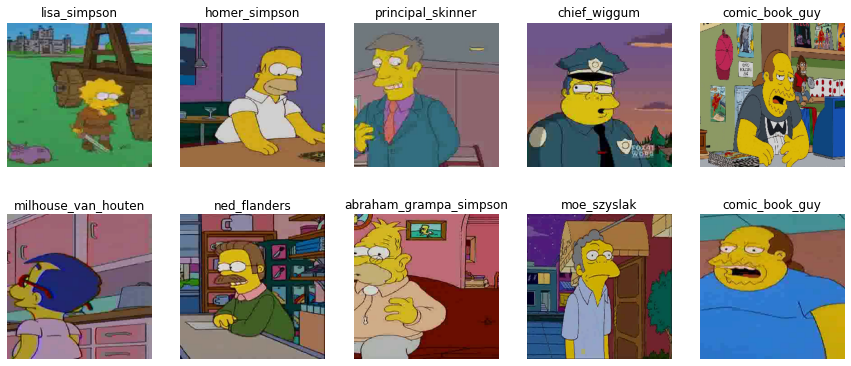

In [8]:
target_labels = next(os.walk(directory_train))[1]

target_labels.sort()

batch = next(train_generator)
batch_images = np.array(batch[0])
batch_labels = np.array(batch[1])

target_labels = np.asarray(target_labels)

plt.figure(figsize=(15,10))
for n, i in enumerate(np.arange(10)):
    ax = plt.subplot(3,5,n+1)
    plt.imshow(batch_images[i])
    plt.title(target_labels[np.where(batch_labels[i]==1)[0][0]])
    plt.axis('off')

# 3. The Benchmark Model

We define a simple CNN to be used as a benchmark model. It uses a combination of 2D convolution layers (to perform spatial convolution over images) with max pooling operations. These are followed by a dense layer with 128 units and ReLU activation function and a dropout layer with a rate of 0.5. Finally, the last layer yields the output of our network, which has a number of units equal to the number of target labels and a softmax activation function. The model was compiled with the Adam optimiser with the default settings and categorical cross entropy loss.

In [9]:
def get_benchmark_model(input_shape):
    x = Input(shape=input_shape)
    h = Conv2D(32, padding='same', kernel_size=(3,3), activation='relu')(x)
    h = Conv2D(32, padding='same', kernel_size=(3,3), activation='relu')(x)
    h = MaxPooling2D(pool_size=(2,2))(h)
    h = Conv2D(64, padding='same', kernel_size=(3,3), activation='relu')(h)
    h = Conv2D(64, padding='same', kernel_size=(3,3), activation='relu')(h)
    h = MaxPooling2D(pool_size=(2,2))(h)
    h = Conv2D(128, kernel_size=(3,3), activation='relu')(h)
    h = Conv2D(128, kernel_size=(3,3), activation='relu')(h)
    h = MaxPooling2D(pool_size=(2,2))(h)
    h = Flatten()(h)
    h = Dense(128, activation='relu')(h)
    h = Dropout(.5)(h)
    output = Dense(target_labels.shape[0], activation='softmax')(h)

    model = tf.keras.Model(inputs=x, outputs=output)
    
    model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])
    return model

Below, one can find the summary of our model, with the detailed list of layers defined and the number of parameters to train for each layer.

In [10]:
benchmark_model = get_benchmark_model((299, 299, 3))
benchmark_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 299, 299, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 149, 149, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 149, 149, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 128)       73856 

We trained the benchmark CNN model using an callback to stop the training process earlier if the validation accuracy is not improved for 10 epochs. This number should be smaller, but it was used to show that the model rapidly starts to overfit the data.

In [11]:
def train_model(model, train_gen, valid_gen, epochs):
    train_steps_per_epoch = train_gen.n // train_gen.batch_size
    val_steps = valid_gen.n // valid_gen.batch_size
    
    earlystopping = tf.keras.callbacks.EarlyStopping(patience=10)
    history = model.fit(train_gen, 
                        steps_per_epoch = train_steps_per_epoch,
                        epochs=epochs,
                        validation_data=valid_gen, 
                        callbacks=[earlystopping])
    
    return history

Every time that we use a generator we need to reset it before feeding it to a model, otherwise we will be loosing batches of data.

In [12]:
train_generator = get_generator(image_gen_train, directory_train, train_valid='training')
validation_generator = get_generator(image_gen_train, directory_train, train_valid='validation')

Found 12411 images belonging to 19 classes.
Found 3091 images belonging to 19 classes.


In [13]:
history_benchmark = train_model(benchmark_model, train_generator, validation_generator, 50)

Epoch 1/50
387/387 [==============================] - 747s 2s/step - loss: 2.8358 - accuracy: 0.1274 - val_loss: 2.4024 - val_accuracy: 0.2436
Epoch 2/50
387/387 [==============================] - 728s 2s/step - loss: 2.3316 - accuracy: 0.2758 - val_loss: 1.9895 - val_accuracy: 0.4170
Epoch 3/50
387/387 [==============================] - 720s 2s/step - loss: 1.9442 - accuracy: 0.3899 - val_loss: 1.8669 - val_accuracy: 0.4426
Epoch 4/50
387/387 [==============================] - 720s 2s/step - loss: 1.5536 - accuracy: 0.5109 - val_loss: 1.6456 - val_accuracy: 0.5241
Epoch 5/50
387/387 [==============================] - 720s 2s/step - loss: 1.2806 - accuracy: 0.5823 - val_loss: 1.6259 - val_accuracy: 0.5299
Epoch 6/50
387/387 [==============================] - 719s 2s/step - loss: 1.0515 - accuracy: 0.6496 - val_loss: 1.6686 - val_accuracy: 0.5490
Epoch 7/50
387/387 [==============================] - 719s 2s/step - loss: 0.8490 - accuracy: 0.7200 - val_loss: 1.6597 - val_accuracy: 0.5613

The figure below shows the accuracy and loss evolution over time (epochs in this case) for the training and validation datasets. Clearly, our model is overfitting the data as the accuracy of the training is close to 90% and the loss of the validation dataset is actually increasing for the last epochs. That is also the reason for the reduced the number of epochs that our model was trained on. 

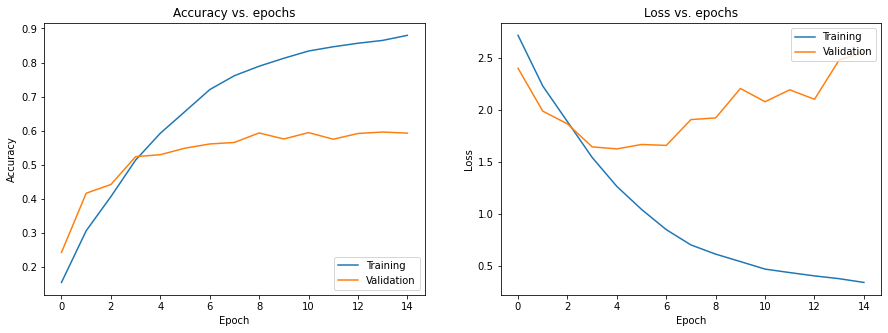

In [14]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(history_benchmark.history['accuracy'])
plt.plot(history_benchmark.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(122)
plt.plot(history_benchmark.history['loss'])
plt.plot(history_benchmark.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

We can evaluate our benchmark model by fitting it to our test dataset. The results are shown below.

In [15]:
test_steps = test_generator.n // test_generator.batch_size
benchmark_test_loss, benchmark_test_acc = benchmark_model.evaluate(test_generator, steps=test_steps)
print('\nTest dataset:')
print("Loss: {}".format(benchmark_test_loss))
print("Accuracy: {}".format(benchmark_test_acc))

29/29 [==============================] - 9s 304ms/step - loss: 2.5011 - accuracy: 0.6272

Test dataset:
Loss: 2.5011332035064697
Accuracy: 0.6271551847457886


# 4. Pre-trained CNN

For the pre-trained model we use the Xception architecture ([[3]](https://arxiv.org/abs/1610.02357), [[4]](https://keras.io/api/applications/xception/)), a deep CNN implemented in the `keras.applications` module. We have loaded the pre-trained parameters (learned on the ImageNet dataset). We use the pre-trained CNN as a large feature extraction layer which we extend with an untrained set of layers specific for our multiclass classification task. This is where the principle of TL is effectively applied.

In [16]:
feature_extractor = tf.keras.applications.Xception(weights="imagenet")

In [17]:
feature_extractor.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [18]:
def remove_head(feature_extractor_model):
    model_input = feature_extractor_model.input
    output = feature_extractor_model.get_layer(name='avg_pool').output
    model = tf.keras.Model(inputs=model_input, outputs=output)
    return model

In [19]:
feature_extractor = remove_head(feature_extractor)
feature_extractor.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [20]:
def add_new_classifier_head(feature_extractor_model):
    model = Sequential([
        feature_extractor_model,
        Dense(128, activation='relu'),
        Dropout(.5),
        Dense(target_labels.shape[0], activation='softmax')
    ])
    
    return model   

Below, we can see the added layers to the head of our model.

In [21]:
new_model = add_new_classifier_head(feature_extractor)
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Functional)         (None, 2048)              20861480  
_________________________________________________________________
dense_2 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 19)                2451      
Total params: 21,126,203
Trainable params: 21,071,675
Non-trainable params: 54,528
_________________________________________________________________


In [22]:
def freeze_pretrained_weights(model):
    model.get_layer(name='model_1').trainable=False
    
    model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    return model

We freeze the pre-trained CNN parameters to be non-trainable - we can see that we have more than 20M non-trainable parameters in our new model. This also results in a smaller training time per epoch, when compared to the benchmark model.

In [23]:
frozen_new_model = freeze_pretrained_weights(new_model)
frozen_new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Functional)         (None, 2048)              20861480  
_________________________________________________________________
dense_2 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 19)                2451      
Total params: 21,126,203
Trainable params: 264,723
Non-trainable params: 20,861,480
_________________________________________________________________


In [24]:
def train_model(model, train_gen, valid_gen, epochs):
    train_steps_per_epoch = train_gen.n // train_gen.batch_size
    val_steps = valid_gen.n // valid_gen.batch_size
    
    history = model.fit(train_gen, 
                        steps_per_epoch = train_steps_per_epoch,
                        epochs=epochs,
                        validation_data=valid_gen)
    
    return history

In [25]:
history_frozen_new_model = train_model(frozen_new_model, train_generator, validation_generator, 50)

Epoch 1/50
387/387 [==============================] - 564s 1s/step - loss: 2.6074 - accuracy: 0.1943 - val_loss: 2.0344 - val_accuracy: 0.4232
Epoch 2/50
387/387 [==============================] - 561s 1s/step - loss: 2.0173 - accuracy: 0.3909 - val_loss: 1.7743 - val_accuracy: 0.5118
Epoch 3/50
387/387 [==============================] - 552s 1s/step - loss: 1.7566 - accuracy: 0.4641 - val_loss: 1.6252 - val_accuracy: 0.5367
Epoch 4/50
387/387 [==============================] - 554s 1s/step - loss: 1.6053 - accuracy: 0.5078 - val_loss: 1.5546 - val_accuracy: 0.5632
Epoch 5/50
387/387 [==============================] - 552s 1s/step - loss: 1.4785 - accuracy: 0.5505 - val_loss: 1.4742 - val_accuracy: 0.5846
Epoch 6/50
387/387 [==============================] - 548s 1s/step - loss: 1.3980 - accuracy: 0.5677 - val_loss: 1.4183 - val_accuracy: 0.5907
Epoch 7/50
387/387 [==============================] - 552s 1s/step - loss: 1.3091 - accuracy: 0.5998 - val_loss: 1.4354 - val_accuracy: 0.5833

We ran the model for a longer number of epochs without using a callback. We do not see the same overfitting pattern, as more than 90% of the weights were frozen. In fact, we could have run it for a small number of epochs as we do not see real improvements after 10 epochs.

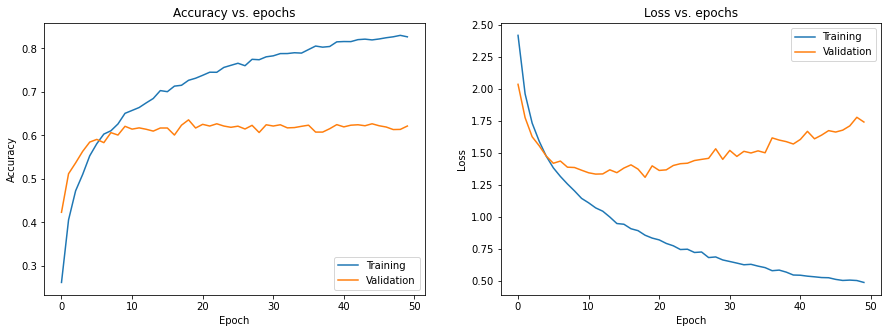

In [26]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(history_frozen_new_model.history['accuracy'])
plt.plot(history_frozen_new_model.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(122)
plt.plot(history_frozen_new_model.history['loss'])
plt.plot(history_frozen_new_model.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

Fitting our new model to the test dataset results in a small accuracy increase (little above 1%).

In [27]:
test_generator = get_generator(image_gen_test, directory_test)
new_model_test_loss, new_model_test_acc = frozen_new_model.evaluate(test_generator, steps=test_steps)
print('\nTest dataset')
print("Loss: {}".format(new_model_test_loss))
print("Accuracy: {}".format(new_model_test_acc))

Found 950 images belonging to 19 classes.
29/29 [==============================] - 33s 1s/step - loss: 1.6086 - accuracy: 0.6390

Test dataset
Loss: 1.6085671186447144
Accuracy: 0.639008641242981


# 5. Data Augmentation

As we saw above, DA is a set of methods used to increase the base dataset while reducing overfitting. We focus on the generic DA that consists on geometric and photometric transformations (see [[5]](https://arxiv.org/pdf/1708.06020.pdf) for more information on these and other methods). Geometric transformations alter the geometry of the image, making the CNN invariant to change in position and orientation. On the other side, photometric transformations make the CNN invariant to changes in color and lighting by adjusting the color channels of the image.

In [28]:
def get_ImageDataGenerator_augmented(validation_split=None):
    image_generator = ImageDataGenerator(rescale=(1/255.),
                                        rotation_range=40,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        shear_range=0.2,
                                        zoom_range=0.1,
                                        brightness_range=[0.8,1.2],
                                        horizontal_flip=True,
                                        validation_split=validation_split)
    return image_generator 

In [29]:
image_gen_train_aug = get_ImageDataGenerator_augmented(validation_split=0.2)

In [30]:
train_generator_aug = get_generator(image_gen_train_aug, directory_train, train_valid='training', seed=1)
validation_generator_aug = get_generator(image_gen_train_aug, directory_train, train_valid='validation')

Found 12411 images belonging to 19 classes.
Found 3091 images belonging to 19 classes.


In [31]:
train_generator = get_generator(image_gen_train, directory_train, train_valid='training', seed=1)

Found 12411 images belonging to 19 classes.


We can display the original images and the augmented images for comparison. Notice the changes in geometry of the images such as by flipping, translation in vertical and horizontal directions or zooming, and in photometry, visible in the altered brightness of some images.

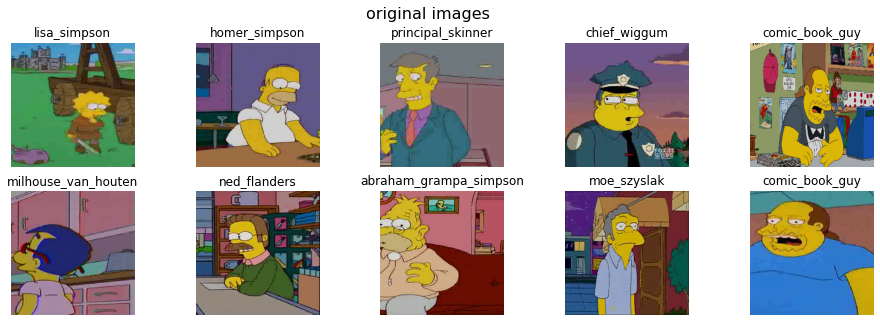

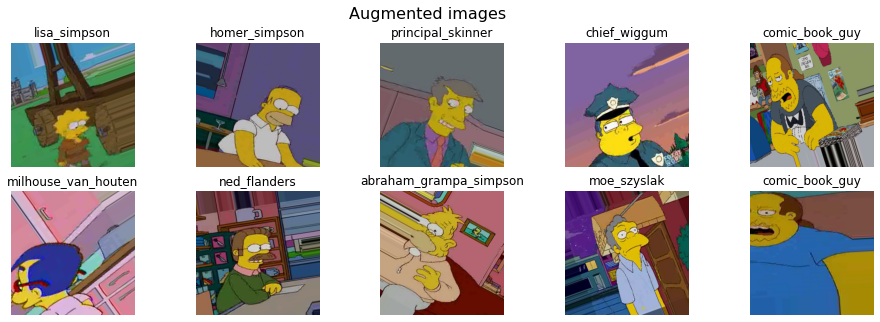

In [32]:
batch = next(train_generator)
batch_images = np.array(batch[0])
batch_labels = np.array(batch[1])

aug_batch = next(train_generator_aug)
aug_batch_images = np.array(aug_batch[0])
aug_batch_labels = np.array(aug_batch[1])

plt.figure(figsize=(16,5))
plt.suptitle("original images", fontsize=16)
for n, i in enumerate(np.arange(10)):
    ax = plt.subplot(2, 5, n+1)
    plt.imshow(batch_images[i])
    plt.title(target_labels[np.where(batch_labels[i]==1)[0][0]])
    plt.axis('off')
plt.figure(figsize=(16,5))
plt.suptitle("Augmented images", fontsize=16)
for n, i in enumerate(np.arange(10)):
    ax = plt.subplot(2, 5, n+1)
    plt.imshow(aug_batch_images[i])
    plt.title(target_labels[np.where(batch_labels[i]==1)[0][0]])
    plt.axis('off')

In [33]:
train_generator_aug = get_generator(image_gen_train_aug, directory_train, train_valid='training')

Found 12411 images belonging to 19 classes.


The augmented dataset is now fed to our custom model (that does not use pre-trained weights) defined above.

In [34]:
benchmark_model_aug = benchmark_model
benchmark_model_aug.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 299, 299, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 149, 149, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 149, 149, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 128)       73856 

In [35]:
history_augmented = train_model(benchmark_model_aug, train_generator_aug, validation_generator_aug, epochs=150)

Epoch 1/150
387/387 [==============================] - 748s 2s/step - loss: 2.1520 - accuracy: 0.3649 - val_loss: 1.8956 - val_accuracy: 0.4426
Epoch 2/150
387/387 [==============================] - 749s 2s/step - loss: 1.8233 - accuracy: 0.4599 - val_loss: 1.6556 - val_accuracy: 0.5273
Epoch 3/150
387/387 [==============================] - 749s 2s/step - loss: 1.6235 - accuracy: 0.5229 - val_loss: 1.5458 - val_accuracy: 0.5590
Epoch 4/150
387/387 [==============================] - 752s 2s/step - loss: 1.4754 - accuracy: 0.5631 - val_loss: 1.4832 - val_accuracy: 0.5794
Epoch 5/150
387/387 [==============================] - 751s 2s/step - loss: 1.3371 - accuracy: 0.6056 - val_loss: 1.4525 - val_accuracy: 0.5930
Epoch 6/150
387/387 [==============================] - 751s 2s/step - loss: 1.2538 - accuracy: 0.6295 - val_loss: 1.3169 - val_accuracy: 0.6364
Epoch 7/150
387/387 [==============================] - 751s 2s/step - loss: 1.1478 - accuracy: 0.6631 - val_loss: 1.1398 - val_accuracy:

387/387 [==============================] - 752s 2s/step - loss: 0.4160 - accuracy: 0.8826 - val_loss: 0.7933 - val_accuracy: 0.8010
Epoch 58/150
387/387 [==============================] - 752s 2s/step - loss: 0.3907 - accuracy: 0.8959 - val_loss: 0.7464 - val_accuracy: 0.8211
Epoch 59/150
387/387 [==============================] - 752s 2s/step - loss: 0.4085 - accuracy: 0.8896 - val_loss: 0.6508 - val_accuracy: 0.8376
Epoch 60/150
387/387 [==============================] - 752s 2s/step - loss: 0.3927 - accuracy: 0.8918 - val_loss: 0.6653 - val_accuracy: 0.8272
Epoch 61/150
387/387 [==============================] - 752s 2s/step - loss: 0.3901 - accuracy: 0.8888 - val_loss: 0.7888 - val_accuracy: 0.8156
Epoch 62/150
387/387 [==============================] - 752s 2s/step - loss: 0.3884 - accuracy: 0.8934 - val_loss: 0.7072 - val_accuracy: 0.8318
Epoch 63/150
387/387 [==============================] - 752s 2s/step - loss: 0.3911 - accuracy: 0.8960 - val_loss: 0.7386 - val_accuracy: 0.830

387/387 [==============================] - 752s 2s/step - loss: 0.2950 - accuracy: 0.9210 - val_loss: 0.6583 - val_accuracy: 0.8602
Epoch 114/150
387/387 [==============================] - 752s 2s/step - loss: 0.3214 - accuracy: 0.9154 - val_loss: 0.6444 - val_accuracy: 0.8580
Epoch 115/150
387/387 [==============================] - 752s 2s/step - loss: 0.3225 - accuracy: 0.9161 - val_loss: 0.5769 - val_accuracy: 0.8583
Epoch 116/150
387/387 [==============================] - 752s 2s/step - loss: 0.3036 - accuracy: 0.9177 - val_loss: 0.6035 - val_accuracy: 0.8564
Epoch 117/150
387/387 [==============================] - 752s 2s/step - loss: 0.3218 - accuracy: 0.9156 - val_loss: 0.6617 - val_accuracy: 0.8505
Epoch 118/150
387/387 [==============================] - 752s 2s/step - loss: 0.3300 - accuracy: 0.9148 - val_loss: 0.6405 - val_accuracy: 0.8522
Epoch 119/150
387/387 [==============================] - 752s 2s/step - loss: 0.3060 - accuracy: 0.9184 - val_loss: 0.6452 - val_accuracy:

Overfitting is clearly not a problem any more. The training can run for a longer number of epochs, since it shows consistently improvements in the metrics. Still, we could have stopped the learning process around epoch number 70 or so, but we extended the process to show that DA can in fact reduce the probability of overfitting. Also, notice that we increased the capacity of our model to recognize the features in the data that belong to each character, as the accuracy on the validation set was raised significantly (to more than 86%).

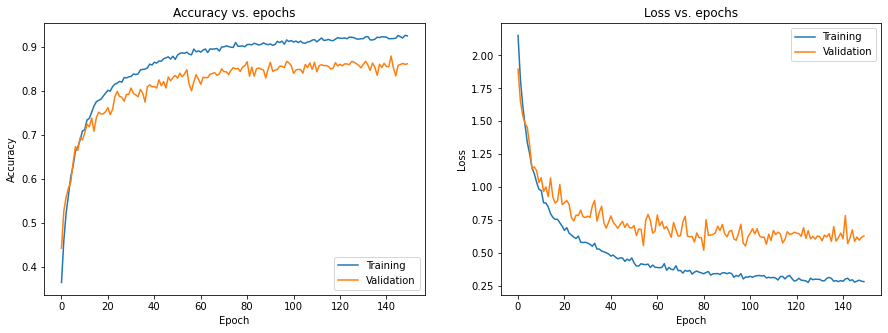

In [36]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(history_augmented.history['accuracy'])
plt.plot(history_augmented.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(122)
plt.plot(history_augmented.history['loss'])
plt.plot(history_augmented.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

Fitting our custom model with augmented data on our test set results in a significantly increased accuracy of more than 91%.

In [37]:
test_generator = get_generator(image_gen_test, directory_test)
augmented_model_test_loss, augmented_model_test_acc = benchmark_model_aug.evaluate(test_generator, steps=test_steps)
print('\nTest dataset')
print("Loss: {}".format(augmented_model_test_loss))
print("Accuracy: {}".format(augmented_model_test_acc))

Found 950 images belonging to 19 classes.
29/29 [==============================] - 9s 307ms/step - loss: 0.4446 - accuracy: 0.9106

Test dataset
Loss: 0.44464701414108276
Accuracy: 0.9105603694915771


# 6. Results

Finally, we can compare the training, validation and test metrics between the benchmark model, the pre-trained model defined using the principle of TL and the custom model with augmented data. The results show that the benchmark model is only slighly surpassed by the TL approach. This is probably due to the nature of the data (domain) where the model was initially trained on and how it transfers to the Simpsons characters domain. On the other hand, the approach using augmented data was able to capture the patterns in the data more effectively, increasing accuracy to more than 91% in the test set.

In [38]:
benchmark_train_loss = history_benchmark.history['loss'][-1]
benchmark_valid_loss = history_benchmark.history['val_loss'][-1]
benchmark_train_acc = history_benchmark.history['accuracy'][-1]
benchmark_valid_acc = history_benchmark.history['val_accuracy'][-1]

new_model_train_loss = history_frozen_new_model.history['loss'][-1]
new_model_valid_loss = history_frozen_new_model.history['val_loss'][-1]
new_model_train_acc = history_frozen_new_model.history['accuracy'][-1]
new_model_valid_acc = history_frozen_new_model.history['val_accuracy'][-1]

augmented_model_train_loss = history_augmented.history['loss'][-1]
augmented_model_valid_loss = history_augmented.history['val_loss'][-1]
augmented_model_train_acc = history_augmented.history['accuracy'][-1]
augmented_model_valid_acc = history_augmented.history['val_accuracy'][-1]

In [39]:
comparison = pd.DataFrame([['Training loss', benchmark_train_loss, new_model_train_loss, augmented_model_train_loss],
                          ['Training accuracy', benchmark_train_acc, new_model_train_acc, augmented_model_train_acc],
                          ['Validation loss', benchmark_valid_loss, new_model_valid_loss, augmented_model_valid_loss],
                          ['Validation accuracy', benchmark_valid_acc, new_model_valid_acc, augmented_model_valid_acc],
                          ['Test loss', benchmark_test_loss, new_model_test_loss, augmented_model_test_loss],
                          ['Test accuracy', benchmark_test_acc, new_model_test_acc, augmented_model_test_acc]],
                           columns=['Metric', 'Benchmark CNN', 'Transfer Learning CNN', 'Custom CNN w/ Data Augmentation'])
comparison.index=['']*6
comparison

,Metric,Benchmark CNN,Transfer Learning CNN,Custom CNN w/ Data Augmentation
,Training loss,0.339907,0.488143,0.282962
,Training accuracy,0.879554,0.826561,0.925923
,Validation loss,2.554460,1.740154,0.628949
,Validation accuracy,0.593012,0.621482,0.862181
,Test loss,2.501133,1.608567,0.444647
,Test accuracy,0.627155,0.639009,0.910560


To illustrate the output of the custom CNN with DA, we plot below predictions for random images in the test set.

In [64]:
test_generator = get_generator(image_gen_test, directory_test, seed=123)
predictions = benchmark_model_aug.predict(test_generator)

Found 950 images belonging to 19 classes.


In [75]:
test_generator = get_generator(image_gen_test, directory_test, seed=123)
batches = []
for i in range(1):
    batches.append(next(test_generator))

batch_images = np.vstack([b[0] for b in batches])
batch_labels = np.concatenate([b[1].astype(np.int32) for b in batches])

Found 950 images belonging to 19 classes.


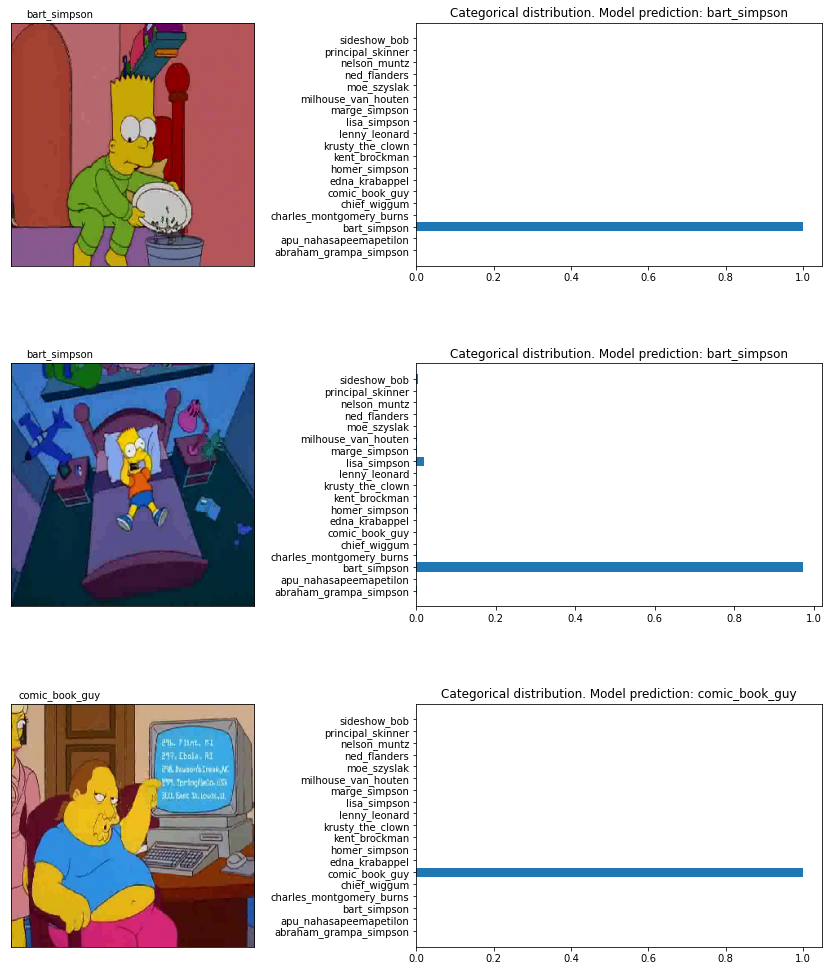

In [257]:
fig, axes = plt.subplots(3, 2, figsize=(16, 17))
fig.subplots_adjust(hspace = 0.4, wspace=0.2)
axes = axes.ravel()

for i in range(3):

    inx = np.random.choice(batch_images.shape[0], 1, replace=False)[0]

    axes[0+i*2].imshow(batch_images[inx])
    axes[0+i*2].get_xaxis().set_visible(False)
    axes[0+i*2].get_yaxis().set_visible(False)
    axes[0+i*2].text(60., -8, target_labels[np.where(batch_labels[inx]==1)[0][0]], 
                    horizontalalignment='center')
    axes[1+i*2].barh(np.arange(len(predictions[inx])),predictions[inx])
    axes[1+i*2].set_yticks(np.arange(len(predictions[inx])))
    axes[1+i*2].set_yticklabels(target_labels)
    axes[1+i*2].set_title(f"Categorical distribution. Model prediction: {target_labels[np.argmax(predictions[inx])]}")
    
plt.show()

# 7. Conclusion

We addressed the problem of having a small dataset and the high likelihood of overfitting using two different approaches. First, we loaded a pre-trained model, from which we remove the top layers and add a specific set of layers required for our task. The second approach tested the usage of DA techniques to inflate our dataset. Our results show that the second approach is able to overcome the limited data and the overfitting problems, yielding very interesting metrics.

For the TL model, more architectures could be tested or even pre-trained networks in different types of datasets. In this case, a pre-trained model on a facial recognition task could yield interesting results. Also, when augmenting our data, more complex transformations could be considered.

# 8. References

[[1]](https://arxiv.org/abs/1911.02685) - [Zhuang et al., 2020] Zhuang, F., Qi, Z., Duan, K., Xi, D., Zhu, Y., Zhu, H., Xiong, H., and He,Q. (2020). A comprehensive survey on transfer learning.

[[2]](https://link.springer.com/chapter/10.1007/978-3-030-01424-7_27) - [Tan et al., 2018] Tan, C., Sun, F., Kong, T., Zhang, W., Yang, C., and Liu, C. (2018). A survey on deep transfer learning.

[[3]](https://arxiv.org/abs/1610.02357) - [Chollet, 2017] Chollet, F. (2017). Xception: Deep learning with depthwise separable convolutions.

[[4]](https://keras.io/api/applications/xception/) - https://keras.io/api/applications/xception/

[[5]](https://arxiv.org/pdf/1708.06020.pdf) - https://arxiv.org/pdf/1708.06020.pdf

[[6]](https://www.kaggle.com/alexattia/the-simpsons-characters-dataset) - https://www.kaggle.com/alexattia/the-simpsons-characters-dataset